# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
%reload_ext autoreload
%autoreload 2

import gc, math, traceback, datetime

import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import load_from_disk

import whisper
from whisper.tokenizer import get_tokenizer

from utils import audio, gradient, gpu
from utils.attacks import PrepareFront, PrepareAtPosition

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# GPU RAM Tracking

In [3]:
device = gpu.get_device()

Device: cuda


# Load Model

In [4]:
try:
    del model
    print("Model deleted!")
except:
    pass

In [5]:
MODEL_NAME = "tiny.en"

model = whisper.load_model(MODEL_NAME).to(device)
model.eval()

target_id, sot_ids = gradient._get_ids(model)

/home/jovyan/libs/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


# Load Data

In [6]:
tedlium_path = "../tedlium"
train_path, validation_path, test_path = f"{tedlium_path}/train_idx.hf", f"{tedlium_path}/validation_idx.hf", f"{tedlium_path}/test.hf"

In [7]:
TRAIN_SELECT = 500
VALID_SELECT = 150
TEST_SELECT = 250

SEED = 1

tedlium_train = load_from_disk(train_path).with_format("torch").shuffle(seed=SEED).select(range(TRAIN_SELECT))
tedlium_validation = load_from_disk(validation_path).with_format("torch").shuffle(seed=SEED).select(range(VALID_SELECT))
tedlium_test = load_from_disk(test_path).with_format("torch").shuffle(seed=SEED).select(range(TEST_SELECT))

Loading dataset from disk:   0%|          | 0/109 [00:00<?, ?it/s]

In [8]:
# def collate(ls):
#     pad_to = max(list(map(lambda x: x["audio"].shape[0], ls)))
#     return torch.cat(list(map(lambda x: F.pad(x["audio"], (0, pad_to - x["audio"].shape[0])).unsqueeze(0).to(torch.bfloat16), ls)), dim=0)

def collate_idx(ls):
    return ls[0]["audio"].unsqueeze(0), ls[0]["idx"].item()

TRAIN_BATCH_SIZE = 1 # highly recommended to be 1
VALID_BATCH_SIZE = 1

train_dataset = DataLoader(tedlium_train, batch_size=TRAIN_BATCH_SIZE, collate_fn=collate_idx)
validation_dataset = DataLoader(tedlium_validation, batch_size=VALID_BATCH_SIZE, collate_fn=collate_idx)
test_dataset = DataLoader(tedlium_test)

# Training Loop

In [9]:
gpu.cleanup()

In [10]:
LR = 1e-3
PATIENCE = 4
MIN_LIMIT = 45
ITER_LIMIT = 30
CLAMP_EP = 0.005
SNIPPET_SIZE = (1, 6800)
POSITION = 0
PREPARE_METHOD = PrepareAtPosition(SNIPPET_SIZE, POSITION)

writer = None

In [11]:
# tensorboard writer
timestamp = datetime.datetime.now().strftime(f'%Y%m%d-%H%M%S_size_{SNIPPET_SIZE}_{PREPARE_METHOD.name}')
writer = SummaryWriter(log_dir=f"../runs/size_tests/{timestamp}", max_queue=5)

In [12]:
best_snippet, snippets, _, _ = gradient.train(model, gradient.forward_auto,
                                              train_dataset, validation_dataset,
                                              PREPARE_METHOD,
                                              writer, lr=LR, 
                                              train_success=None, valid_success=None,
                                              iter_limit=ITER_LIMIT, mins_limit=MIN_LIMIT, patience=PATIENCE, clamp_epsilon=CLAMP_EP)

/home/jovyan/libs/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Prepare method: prepare_at_position
Snippet initialised to [3.918242725831078e-07, 0.004999210592359304] of size (1, 6800)
Clamp: 0.005
Time Limit (Mins): 45
Epochs Limit: 30
Tracking training success: False
Tracking valid success: False


Training:   0% 0/1 [03:29<?, ?it/s, Iter 1, Validation Batch 150/150]

Trng Avg Loss: 6.16392055746913 | Valid Avg Loss: 6.476312637329102 | Patience: 4 | LR: [0.001] | Epoch Limit: 29


Training:   0% 0/1 [05:30<?, ?it/s, Iter 2, Validation Batch 150/150]

Trng Avg Loss: 4.450537734761834 | Valid Avg Loss: 6.484608173370361 | Patience: 3 | LR: [0.001] | Epoch Limit: 28


Training:   0% 0/1 [07:27<?, ?it/s, Iter 3, Validation Batch 150/150]

Trng Avg Loss: 3.888682283051312 | Valid Avg Loss: 5.591642379760742 | Patience: 4 | LR: [0.001] | Epoch Limit: 27


Training:   0% 0/1 [09:21<?, ?it/s, Iter 4, Validation Batch 150/150]

Trng Avg Loss: 4.148744143726304 | Valid Avg Loss: 6.66834831237793 | Patience: 3 | LR: [0.001] | Epoch Limit: 26


Training:   0% 0/1 [11:17<?, ?it/s, Iter 5, Validation Batch 150/150]

Trng Avg Loss: 4.170319392032921 | Valid Avg Loss: 5.958902359008789 | Patience: 2 | LR: [0.001] | Epoch Limit: 25


Training:   0% 0/1 [12:47<?, ?it/s, Iter 7, Training Batch 1/500]    

Trng Avg Loss: 1.5043940699500964 | Valid Avg Loss: 0.20201587677001953 | Patience: 4 | LR: [0.0005] | Epoch Limit: 24


Training:   0% 0/1 [14:10<?, ?it/s, Iter 8, Training Batch 2/500]    

Trng Avg Loss: 0.8277688898737542 | Valid Avg Loss: 3.270780563354492 | Patience: 3 | LR: [0.0005] | Epoch Limit: 23


Training:   0% 0/1 [15:31<?, ?it/s, Iter 8, Validation Batch 150/150]

Trng Avg Loss: 0.9576996125294827 | Valid Avg Loss: 0.1792203038930893 | Patience: 4 | LR: [0.0005] | Epoch Limit: 22


Training:   0% 0/1 [16:51<?, ?it/s, Iter 9, Validation Batch 150/150]

Trng Avg Loss: 0.5149734089644625 | Valid Avg Loss: 0.20673829317092896 | Patience: 3 | LR: [0.0005] | Epoch Limit: 21


Training:   0% 0/1 [18:12<?, ?it/s, Iter 10, Validation Batch 150/150]

Trng Avg Loss: 0.7627579418057576 | Valid Avg Loss: 0.5944235920906067 | Patience: 2 | LR: [0.0005] | Epoch Limit: 20


Training:   0% 0/1 [19:29<?, ?it/s, Iter 11, Validation Batch 150/150]

Trng Avg Loss: 0.2099382188753225 | Valid Avg Loss: 0.13223369419574738 | Patience: 4 | LR: [0.00025] | Epoch Limit: 19


Training:   0% 0/1 [20:45<?, ?it/s, Iter 12, Validation Batch 150/150]

Trng Avg Loss: 0.1871600310744252 | Valid Avg Loss: 0.11767404526472092 | Patience: 4 | LR: [0.00025] | Epoch Limit: 18


Training:   0% 0/1 [22:08<?, ?it/s, Iter 13, Validation Batch 150/150]

Trng Avg Loss: 0.503814564446453 | Valid Avg Loss: 0.1666763722896576 | Patience: 3 | LR: [0.00025] | Epoch Limit: 17


Training:   0% 0/1 [23:28<?, ?it/s, Iter 14, Validation Batch 150/150]

Trng Avg Loss: 0.40238951846421694 | Valid Avg Loss: 0.2911270558834076 | Patience: 2 | LR: [0.00025] | Epoch Limit: 16


Training:   0% 0/1 [24:49<?, ?it/s, Iter 15, Validation Batch 150/150]

Trng Avg Loss: 0.2854638881965075 | Valid Avg Loss: 0.12903521955013275 | Patience: 1 | LR: [0.00025] | Epoch Limit: 15


Training:   0% 0/1 [26:06<?, ?it/s, Iter 16, Validation Batch 150/150]

Trng Avg Loss: 0.07862002766062505 | Valid Avg Loss: 0.11593789607286453 | Patience: 4 | LR: [0.000125] | Epoch Limit: 14


Training:   0% 0/1 [27:21<?, ?it/s, Iter 17, Validation Batch 150/150]

Trng Avg Loss: 0.024287654133862815 | Valid Avg Loss: 0.08932062983512878 | Patience: 4 | LR: [0.000125] | Epoch Limit: 13


Training:   0% 0/1 [28:38<?, ?it/s, Iter 19, Training Batch 1/500]    

Trng Avg Loss: 0.010453811890212819 | Valid Avg Loss: 0.03308624401688576 | Patience: 4 | LR: [0.000125] | Epoch Limit: 12


Training:   0% 0/1 [29:53<?, ?it/s, Iter 20, Training Batch 1/500]    

Trng Avg Loss: 0.0059535234750946985 | Valid Avg Loss: 0.030278433114290237 | Patience: 4 | LR: [0.000125] | Epoch Limit: 11


Training:   0% 0/1 [31:10<?, ?it/s, Iter 21, Training Batch 2/500]    

Trng Avg Loss: 0.004531566507532261 | Valid Avg Loss: 0.027702542021870613 | Patience: 4 | LR: [0.000125] | Epoch Limit: 10


Training:   0% 0/1 [32:27<?, ?it/s, Iter 21, Validation Batch 150/150]

Trng Avg Loss: 0.0035071047673700378 | Valid Avg Loss: 0.0251054298132658 | Patience: 4 | LR: [6.25e-05] | Epoch Limit: 9


Training:   0% 0/1 [33:46<?, ?it/s, Iter 22, Validation Batch 150/150]

Trng Avg Loss: 0.0030052369998011274 | Valid Avg Loss: 0.02557208389043808 | Patience: 3 | LR: [6.25e-05] | Epoch Limit: 8


Training:   0% 0/1 [35:04<?, ?it/s, Iter 24, Training Batch 1/500]    

Trng Avg Loss: 0.002724761146469973 | Valid Avg Loss: 0.024569882079958916 | Patience: 4 | LR: [6.25e-05] | Epoch Limit: 7


Training:   0% 0/1 [36:22<?, ?it/s, Iter 24, Validation Batch 150/150]

Trng Avg Loss: 0.0025978395820129663 | Valid Avg Loss: 0.024113882333040237 | Patience: 4 | LR: [6.25e-05] | Epoch Limit: 6


Training:   0% 0/1 [37:38<?, ?it/s, Iter 25, Validation Batch 150/150]

Trng Avg Loss: 0.0024078178176132497 | Valid Avg Loss: 0.02371038682758808 | Patience: 4 | LR: [6.25e-05] | Epoch Limit: 5


Training:   0% 0/1 [38:54<?, ?it/s, Iter 26, Validation Batch 150/150]

Trng Avg Loss: 0.0020693877988669554 | Valid Avg Loss: 0.021966073662042618 | Patience: 4 | LR: [3.125e-05] | Epoch Limit: 4


Training:   0% 0/1 [40:11<?, ?it/s, Iter 28, Training Batch 1/500]    

Trng Avg Loss: 0.0018262776922201738 | Valid Avg Loss: 0.02149641327559948 | Patience: 4 | LR: [3.125e-05] | Epoch Limit: 3


Training:   0% 0/1 [41:27<?, ?it/s, Iter 28, Validation Batch 150/150]

Trng Avg Loss: 0.0016741655040532352 | Valid Avg Loss: 0.012137788347899914 | Patience: 4 | LR: [3.125e-05] | Epoch Limit: 2


Training:   0% 0/1 [42:43<?, ?it/s, Iter 29, Validation Batch 150/150]

Trng Avg Loss: 0.0016640889759873972 | Valid Avg Loss: 0.012601007707417011 | Patience: 3 | LR: [3.125e-05] | Epoch Limit: 1


Training:   0% 0/1 [42:44<?, ?it/s, Epoch limit reached! Terminating...]


Cleared buffer
Cleared loss


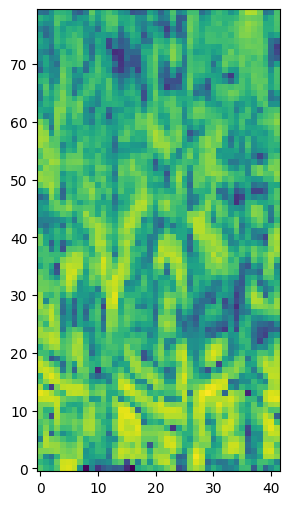

In [13]:
audio.view_mel(best_snippet.detach().to("cpu").squeeze())

# Evaluation

In [14]:
gradient.evaluate(model, best_snippet, PREPARE_METHOD, test_dataset, CLAMP_EP, POSITION) # commented to prevent the runtime from autorunning and crashing the thing

Clamp: 0.005
Prepare Method: prepare_at_position
Snippet Size: (1, 6800)
Position: 0


Inference: 100%|██████████| 250/250 [00:54<00:00,  4.59it/s, Valid Examples: 194 | Empty Sequences: 193 | Total SL: 96 | Non-empty ASL: 96.0 | Total Bleu Score: 0.800000011920929]



Total valid examples: 194
Success rate (Empty): 0.9948453608247423
Success rate (ASL): 0.4948453608247423 (attacked) out of 122.16494845360825 (original)
Average Bleu Score: 0.800000011920929


In [15]:
random_snippet = torch.rand(SNIPPET_SIZE) * CLAMP_EP
gradient.evaluate(model, random_snippet, PREPARE_METHOD, test_dataset, CLAMP_EP, POSITION) # commented to prevent the runtime from autorunning and crashing the thing

Clamp: 0.005
Prepare Method: prepare_at_position
Snippet Size: (1, 6800)
Position: 0


Inference: 100%|██████████| 250/250 [00:51<00:00,  4.90it/s, Valid Examples: 194 | Empty Sequences: 0 | Total SL: 23731 | Non-empty ASL: 122.32474226804123 | Total Bleu Score: 126.20443725585938]



Total valid examples: 194
Success rate (Empty): 0.0
Success rate (ASL): 122.32474226804123 (attacked) out of 122.16494845360825 (original)
Average Bleu Score: 0.6505383253097534


# Save Tensors

In [16]:
snippets = torch.stack(list(map(lambda x: x.cpu(), snippets)) + [best_snippet.cpu()])
snippets.shape

torch.Size([31, 1, 6800])

In [17]:
# torch.save(snippets.squeeze(), "snippets.pt")

In [18]:
# torch.save(torch.stack(list(map(torch.tensor, train_success.values()))), "train_success.pt")
# torch.save(torch.tensor(list(train_success.keys())), "train_ids.pt")

In [19]:
# torch.save(torch.stack(list(map(torch.tensor, valid_success.values()))), "valid_success.pt")
# torch.save(torch.tensor(list(valid_success.keys())), "valid_ids.pt")

# Save and Hear Snippet

In [20]:
# def normalise(random_snippet, ep):
#     # we assume torch.rand inits to [0, 1)
#     res = random_snippet * ep * 2 - ep
#     print(f"Normalised, Min {torch.min(res)}, Max {torch.max(res)}")
#     return res

In [21]:
# Save snippet to wav file
# save_audio(snippet, f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_snippet_only.wav")

In [22]:
# save_audio(PREPARE_METHOD(snippet.to("cpu"), tedlium_test[2]["audio"].unsqueeze(0)), f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_combined.wav")